In [0]:
ls

sample_data/


In [0]:
!pip install fastai==0.7.0
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install torchtext==0.3.1

import torch
!pip install pillow==5.3.0
!pip install image
!pip install matplotlib==2.2.3
%matplotlib inline
!pip install pathlib
from fastai.imports import *

!wget http://files.fast.ai/models/weights.tgz
!tar -xvzf weights.tgz -C /usr/local/lib/python3.6/dist-packages/fastai/


====================================== RESTART RUNTIME

In [0]:
import os
import shutil

from google.colab import drive
drive.mount('/content/gdrive')
colab_dir = '/content/gdrive/My Drive/Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
kaggle_file = os.path.expanduser("~/.kaggle/kaggle.json")
os.makedirs(os.path.dirname(kaggle_file), exist_ok=True)
shutil.copy(os.path.join(colab_dir, os.path.basename(kaggle_file)), kaggle_file)

!pip install kaggle
!kaggle competitions download -c human-protein-atlas-image-classification

!unzip -q -d train train.zip
!unzip -q -d test test.zip
!rm *.zip


  0% 0.00/446k [00:00<?, ?B/s]
100% 446k/446k [00:00<00:00, 30.7MB/s]
  0% 0.00/1.22M [00:00<?, ?B/s]
100% 1.22M/1.22M [00:00<00:00, 52.9MB/s]
100% 4.36G/4.37G [00:39<00:00, 127MB/s]
100% 4.37G/4.37G [00:39<00:00, 120MB/s]
100% 13.1G/13.1G [02:03<00:00, 112MB/s]
100% 13.1G/13.1G [02:04<00:00, 113MB/s]


### Overview
The goal of this competition is classification of mixed protein patterns. However, unlike most image labeling tasks, where binary or multiclass labeling is considered, in this competition each image can have multiple labels. Multiclass multilabel task has its own specific affecting the design of the model and the loss function. Moreover, the classified images are quite different from ImageNet; therefore, despite usage of a pretrained model is quite helpful, a substantial retraining of entire model is needed. An additional challenge is 4-chanel input to the model (RGBY), which is different from ones used in most of pretrained models (RGB input).

In this kernel I will show how to handle the above challenges and get started with this competition. I will begin with using a light ResNet34 model and low-resolution images to have a baseline that can be used later to select higher end models and explore the effect of image resolution on the prediction accuracy. **The validation F1 score of the model is ~0.65-0.7**, and I was able to get 0.460 public LB score in V11 of the kernel (0.453 after reset of the LB). Though reuslts are slightly different from one run to another because F1 macro metric is unstable, and sevral items of rear classes contribute in the same way as as thousands items of common classes, 1/28.

The problem of low public LB score of the model, which mentioned in the first versions of the kernel, is resulted by a bug in the evaluation metric (https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/69366#409041) that relies on the order of records in the submission file rather than IDs.

In [0]:
!pip install fastai==0.7.0 --no-deps
!pip install torch==0.4.1 torchvision==0.2.1

In [0]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [0]:
PATH = './'
TRAIN = './train/'
TEST = './test/'
LABELS = './train.csv'
SPLIT = os.path.join(colab_dir, 'protein_competition')
nw = 2   #number of workers for data loader

In [0]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

### Data

In [0]:
#using a split that includes all classes in val
with open(os.path.join(SPLIT,'tr_names.txt'), 'r') as text_file:
    tr_n = text_file.read().split(',')
with open(os.path.join(SPLIT,'val_names.txt'), 'r') as text_file:
    val_n = text_file.read().split(',')
test_names = sorted({f[:36] for f in os.listdir(TEST)})
print(len(tr_n),len(val_n))

28575 2497


In [0]:
#creating duplicates for rare classes in train set
class Oversampling:
    def __init__(self,path):
        self.train_labels = pd.read_csv(path).set_index('Id')
        self.train_labels['Target'] = [[int(i) for i in s.split()] 
                                       for s in self.train_labels['Target']]  
        #set the minimum number of duplicates for each class
        self.multi = [1,1,1,1,1,1,1,1,
                      4,4,4,1,1,1,1,4,
                      1,1,1,1,2,1,1,1,
                      1,1,1,4]

    def get(self,image_id):
        labels = self.train_labels.loc[image_id,'Target'] if image_id \
          in self.train_labels.index else []
        m = 1
        for l in labels:
            if m < self.multi[l]: m = self.multi[l]
        return m
    
s = Oversampling(os.path.join(PATH,LABELS))
tr_n = [idx for idx in tr_n for _ in range(s.get(idx))]
print(len(tr_n),flush=True)

29016


In [0]:
def open_rgby(path,id): #a function that reads RGBY image
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

Since a multiclass multilabel task is considered, there are several things about the model that should be pointed out. First, the SOFTMAX MUST NOT BE USED as an output layer because it encourages a single label prediction. The common output function for multilabel tasks is sigmoid. However, combining the sigmoid with the loss function (like in BCE with logits loss or in Focal loss used in this kernel) allows log(sigmoid) optimization of the numerical stability of the loss function. Therefore, sigmoid is also removed.

In [0]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        return open_rgby(self.path,self.fnames[i])
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [0]:
def get_data(sz,bs,is_test=False):
    #data augmentation
    if is_test:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO)]
    else:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO),
                Cutout(n_holes=25, length=10*sz//128, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [0]:
bs = 16
sz = 512 #256
md = get_data(sz,bs,is_test=True)

x,y = next(iter(md.aug_dl))
x.shape, y.shape

(torch.Size([16, 4, 512, 512]), torch.Size([16, 28]))

Plot several examples of input images.

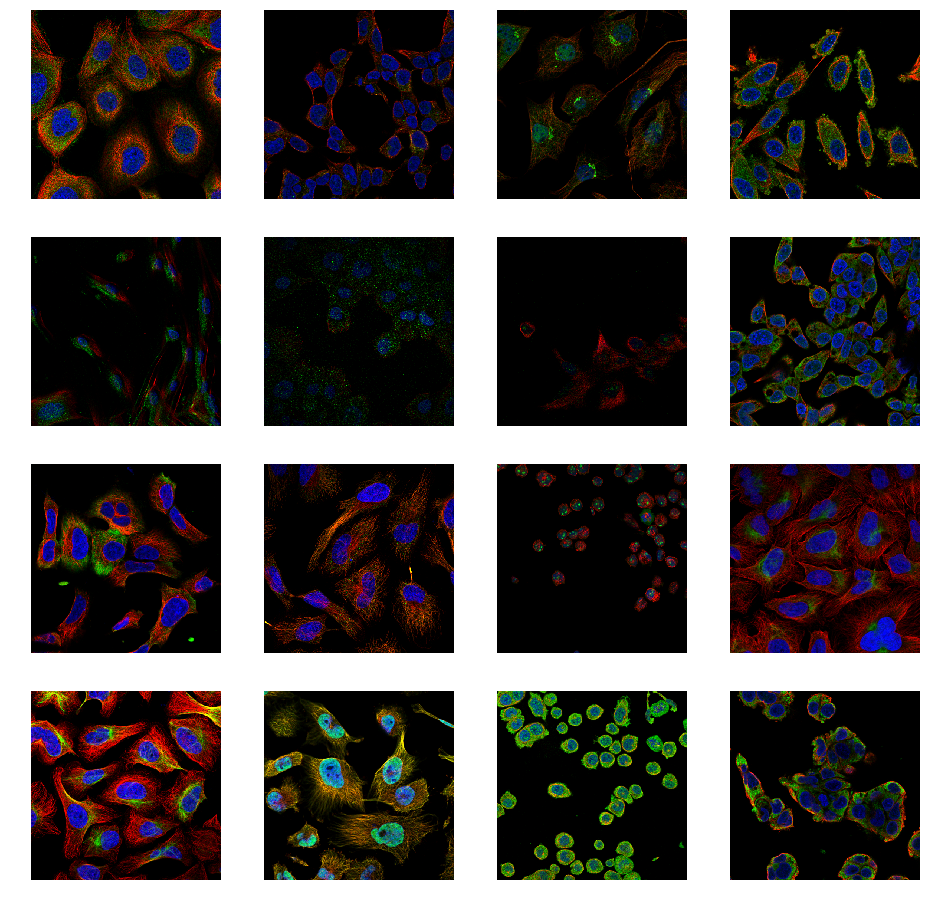

In [0]:
def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4,4)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx,:,:,:3]*255).astype(np.int))
    plt.show()
    
display_imgs(np.asarray(md.trn_ds.denorm(x)))

Computing image statistics in the train set. The values listed below are computed without augmentation, therefore the result of the next cell may be a little bit different.
1. train: (array([0.08069, 0.05258, 0.05487, 0.08282]), array([0.13704, 0.10145, 0.15313, 0.13814]))
1. test: (array([0.05913, 0.0454 , 0.04066, 0.05928]),  array([0.11734, 0.09503, 0.129  , 0.11528]))

In [0]:
#x_tot = np.zeros(4)
#x2_tot = np.zeros(4)
#for x,y in iter(md.trn_dl):
#    x = md.trn_ds.denorm(x).reshape(-1,4)
#    x_tot += x.mean(axis=0)
#    x2_tot += (x**2).mean(axis=0)

#channel_avr = x_tot/len(md.trn_dl)
#channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
#channel_avr,channel_std

### Model

One of the challenges in this competition is 4-chanel input (RGBY) that limits usage of ImageNet pretrained models taking RGB input. However, the input dataset is too tiny to train even a low capacity model like ResNet34 from scratch. Therefore, I replace the first convolution layer from 7x7 3->64 to 7x7 **4->64** while keeping weights from 3->64. As suggested by @[Skylum] OleksandrSavsunenko in comments, the weights for the last channel can be initialized with values from other channels (the model requires substantial retraining in any case). Also, as @Artyom Palvelev pinted out, the weights should not be set to zero.

In [0]:
class Resnet34_4(nn.Module):
    def __init__(self, pre=True):
        super().__init__()
        encoder = resnet50(pretrained=pre) #resnet34(pretrained=pre)
        
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        if(pre):
            w = encoder.conv1.weight
            self.conv1.weight = nn.Parameter(torch.cat((w,
                                    0.5*(w[:,:1,:,:]+w[:,2:,:,:])),dim=1))
        
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True) 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = nn.Sequential(self.conv1,self.relu,self.bn1,self.maxpool)
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        #the head will be added automatically by fast.ai
        
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        return x

### Loss function and metrics

One of the challenges of this competition is strong data imbalance. Some classes, like "Nucleoplasm", are very common, while there is a number of rare classes, like "Endosomes", "Lysosomes", and "Rods & rings". In addition, in tasks of multiclass, and especially in multilabel, classification there is always an issue with data imbalance: if you predict 1 class out of 10, given the same number of examples per each class, you have 1 positive vs. 9 negative examples. So, it is crucial to use a loss function that accounts for it. Recently proposed focal loss (https://arxiv.org/pdf/1708.02002.pdf) has revolutionized one stage object localization method in 2017. It is design to address the issue of strong data imbalance, demonstrating amazing results on datasets with imbalance level 1:10-1000. In particular, it works quite well for image segmentation task in "Airbus Ship Detection Challenge": https://www.kaggle.com/iafoss/unet34-dice-0-87 .  The implementation of focal loss is borrowed from https://becominghuman.ai/investigating-focal-and-dice-loss-for-the-kaggle-2018-data-science-bowl-65fb9af4f36c .

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [0]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

Class for accumulation the statistics on each batch and culculation F1 score for entire val dataset.

In [0]:
class F1:
    __name__ = 'F1 macro'
    def __init__(self,n=28):
        self.n = n
        self.TP = np.zeros(self.n)
        self.FP = np.zeros(self.n)
        self.FN = np.zeros(self.n)

    def __call__(self,preds,targs,th=0.0):
        preds = (preds > th).int()
        targs = targs.int()
        self.TP += (preds*targs).float().sum(dim=0)
        self.FP += (preds > targs).float().sum(dim=0)
        self.FN += (preds < targs).float().sum(dim=0)
        score = (2.0*self.TP/(2.0*self.TP + self.FP + self.FN + 1e-6)).mean()
        return score

    def reset(self):
        #macro F1 score
        score = (2.0*self.TP/(2.0*self.TP + self.FP + self.FN + 1e-6))
        print('F1 macro:',score.mean(),flush=True)
        #print('F1:',score)
        self.TP = np.zeros(self.n)
        self.FP = np.zeros(self.n)
        self.FN = np.zeros(self.n)

class F1_callback(Callback):
    def __init__(self, n=28):
        self.f1 = F1(n)

    def on_epoch_end(self, metrics):
        self.f1.reset()

### Training

In [0]:
sz = 512 #256 #image size
bs = 16 #64  #batch size

md = get_data(sz,bs)
learner = ConvLearner.pretrained(Resnet34_4, md, ps=0.5) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
f1_callback = F1_callback()
learner.metrics = [acc,f1_callback.f1]
learner.summary

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 24395317.95it/s]
/usr/local/lib/python3.6/dist-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


<bound method ConvLearner.summary of Sequential(
  (0): Resnet34_4(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer0): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fa

I begin with finding the optimal learning rate. The following function runs training with different lr and records the loss. Increase of the loss indicates onset of divergence of training. The optimal lr lies in the vicinity of the minimum of the curve but before the onset of divergence. Based on the following plot, for the current setup the divergence starts at ~0.05, and the recommended learning rate is ~0.005.

 67%|██████▋   | 1210/1813 [20:06<09:30,  1.06it/s, loss=6.44]

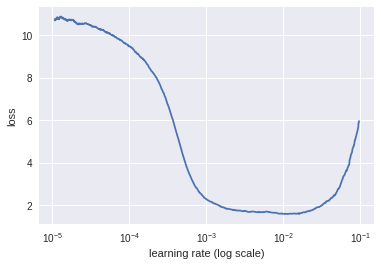

In [0]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find()
learner.sched.plot()

First, I train only the head of the model while keeping the rest frozen. It allows to avoid corruption of the pretrained weights at the initial stage of training due to random initialization of the head layers. So the power of transfer learning is fully utilized when the training is continued. **When you check F1 macro metric, look at "F1 macro: XXX"** before the epoch number, which shows the result calculated for entire val dataset.

In [0]:
lr = 0.5e-2
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lr,1,callbacks=[f1_callback])

F1 macro: 0.04182980131001158
epoch      trn_loss   val_loss   acc        F1 macro   
    0      1.275599   1.503357   0.937725   0.04448   


Next, I unfreeze all weights and allow training of entire model. One trick that I use is differential learning rate: the lr of the head part is still lr, while the middle layers of the model are trained with lr/3, and the base is trained with even smaller lr/10. Despite the low-level detectors do not vary much from one image data set to another much, the yellow channel should be trained, and also the images are quite different from ImageNet; therefore, the I decrease the learning rate for first layers only by 10 times. If there was no necessity to train an additional channel and the images were more similar to ImageNet, the learning rates could be [lr/100,lr/10,lr]. Another trick is learning rate annealing. Periodic lr increase followed by slow decrease drives the system out of steep minima (when lr is high) towards broader ones (which are explored when lr decreases) that enhances the ability of the model to generalize and reduces overfitting. The length of the cycles gradually increases during training. 

In [0]:
lr = 0.5e-2
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [0]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20),callbacks=[f1_callback])
learner.save(os.path.join(colab_dir, 'model_step1'))

F1 macro: 0.26236672215155105
epoch      trn_loss   val_loss   acc        F1 macro   
    0      0.886741   1.964412   0.950641   0.26306   
F1 macro: 0.36715718382645823
    1      0.801732   1.405293   0.957177   0.352268  
F1 macro: 0.2942514762531502
    2      0.797291   0.984204   0.955547   0.279209  
F1 macro: 0.46827042524921947
    3      0.71254    0.813298   0.962012   0.451942  
F1 macro: 0.4677282153201179
    4      0.778104   0.8976     0.960925   0.449075  
F1 macro: 0.5093501049444685
    5      0.675053   0.878751   0.964343   0.484534  
F1 macro: 0.44951749062689056
    6      0.730729   0.836173   0.961525   0.446371  
F1 macro: 0.5340826842634716
    7      0.656957   0.803757   0.964715   0.514872  


In [0]:
learner.load(os.path.join(colab_dir, 'model_step1'))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/16,2,cycle_len=4,use_clr=(10,20),callbacks=[f1_callback])
learner.save(os.path.join(colab_dir, 'model_step2'))

F1 macro: 0.5598177630214567
epoch      trn_loss   val_loss   acc        F1 macro   
    0      0.659579   0.742077   0.965087   0.530351  
F1 macro: 0.5703122827349025
    1      0.635042   0.742355   0.965416   0.538262  
F1 macro: 0.5861991428787181
    2      0.617527   0.711809   0.96636    0.551408  
F1 macro: 0.6023872686814632
    3      0.63878    0.739548   0.966817   0.585296  
F1 macro: 0.613576455417557
    4      0.615036   0.714713   0.966789   0.576302  
F1 macro: 0.6040027404309519
    5      0.614826   0.711884   0.966917   0.575939  
F1 macro: 0.618127000469555
    6      0.625364   0.702028   0.967475   0.586795  
F1 macro: 0.6230381078337951
    7      0.598309   0.69829    0.967804   0.592062  



In [0]:
learner.sched.plot_lr()

In [0]:
learner.load(os.path.join(colab_dir, 'model_step2'))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/32,1,cycle_len=8,use_clr=(10,20),callbacks=[f1_callback])
learner.save(os.path.join(colab_dir, 'model_step3'))

F1 macro: 0.6549362578120826
epoch      trn_loss   val_loss   acc        F1 macro   
    0      0.588078   0.682977   0.968019   0.614043  
F1 macro: 0.6380821649658804
    1      0.580314   0.678586   0.968848   0.605321  
F1 macro: 0.647437740446547
    2      0.585856   0.666604   0.968863   0.606996  
F1 macro: 0.6500211455007322
    3      0.581498   0.670385   0.968677   0.61061   
F1 macro: 0.647022223798247
    4      0.566867   0.665036   0.968662   0.611876  
F1 macro: 0.6667862800648512
    5      0.545552   0.661442   0.96922    0.631012  
F1 macro: 0.6556729585447344
    6      0.546484   0.662015   0.969106   0.621372  
 31%|███       | 563/1813 [22:18<54:28,  2.62s/it, loss=0.552]

Save the model for further use or training on higher resolution images.

In [0]:
learner.save('ResNet34_256_1')

### Validation score

In [0]:
learner.load(os.path.join(colab_dir, 'model_step3'))

Evaluate the score with using TTA (test time augmentation).

In [0]:
md = get_data(sz,bs,is_test=True)
learner.set_data(md)
preds,y = learner.TTA(n_aug=8)
preds = np.stack(preds, axis=-1)
pred = preds.mean(axis=-1)

Instead of 0.5, one can adjust the values of the threshold for each class individually to boost the score. The code below does it automatically.

In [0]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.0,d=25.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [0]:
th = fit_val(pred,y)
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.0): ',f1_score(y, pred>0.0, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

Thresholds:  [ 0.04198 -0.09447 -0.43555 -0.41927 -0.50718 -0.3421  -0.59998 -0.20982  0.44042 -0.12436 -0.23927 -0.12537
 -0.40822 -0.68895 -0.40654 -0.47639 -0.98563 -0.8744  -0.50594 -0.44637 -0.48407 -0.26156 -0.65546 -0.33508
 -0.51793 -0.18627 -0.18378 -0.41705]
F1 macro:  0.7169139737500722
F1 macro (th = 0.0):  0.6405267907954195
F1 micro:  0.757400327689787


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 5800.
  warnings.warn(errors[info][0], RuntimeWarning)


Using CV to prevent overfitting the thresholds:

In [0]:
from sklearn.model_selection import train_test_split
th, score, cv = 0,0,10
for i in range(cv):
    xt,xv,yt,yv = train_test_split(pred,y,test_size=0.5,random_state=i)
    th_i = fit_val(xt,yt)
    th += th_i
    score += f1_score(yv, xv>th_i, average='macro')
th/=cv
score/=cv
print('Thresholds: ',th)
print('F1 macro avr:',score)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 5800.
  warnings.warn(errors[info][0], RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Thresholds:  [ 0.03623 -0.12764 -0.32219 -0.34323 -0.46823 -0.23435 -0.59916 -0.24003  0.13446  0.00035 -0.15456 -0.12424
 -0.43257 -0.63428 -0.31085 -0.37281 -0.71315 -0.86459 -0.4939  -0.37521 -0.48845 -0.27937 -0.34795 -0.32949
 -0.30411 -0.20637 -0.2566  -0.22656]
F1 macro avr: 0.6675081979380936
F1 macro:  0.7082420986490935
F1 micro:  0.7540947321823815


In [0]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > 0.5).mean(axis=0))

Fractions:  [0.39007 0.07329 0.10853 0.06648 0.06608 0.06608 0.06007 0.0845  0.0028  0.002   0.002   0.05527 0.03124
 0.02403 0.07129 0.0016  0.03164 0.01842 0.04525 0.07649 0.00761 0.10493 0.03044 0.0793  0.01482 0.26071
 0.01602 0.0008 ]
Fractions (true):  [0.36083 0.07809 0.11614 0.07048 0.07649 0.0793  0.06688 0.08851 0.00481 0.0032  0.0024  0.06808 0.03885
 0.03484 0.07289 0.002   0.03604 0.01642 0.03965 0.07329 0.01362 0.10292 0.03724 0.0853  0.01762 0.22467
 0.01482 0.0016 ]


Plot the distribution of lables to see how the model performs. Be aware about **log scale**.

Nucleoplasm 0 0.832 0.03623219220288726


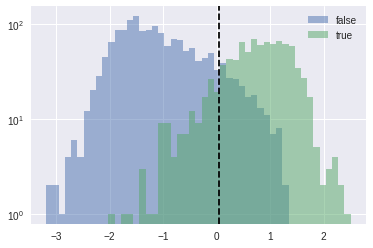

Nuclear membrane 1 0.8994708994708994 -0.127640253180119


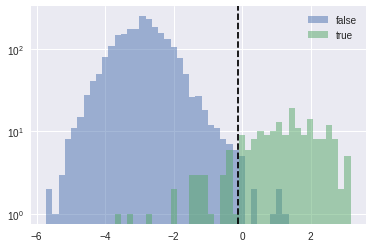

Nucleoli 2 0.8092691622103387 -0.3221934791920826


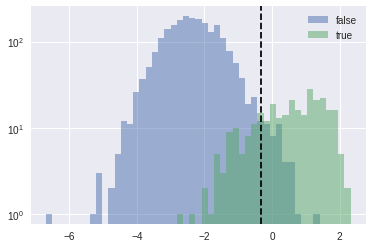

Nucleoli fibrillar center 3 0.801169590643275 -0.3432286987165395


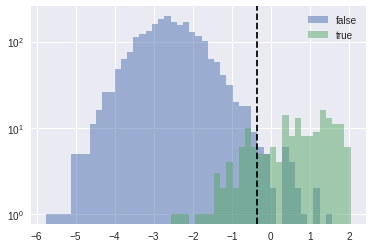

Nuclear speckles 4 0.8258426966292135 -0.4682283079852575


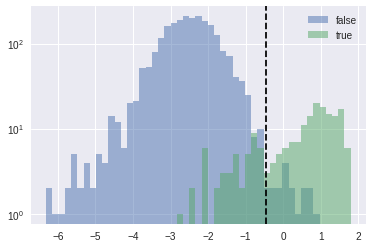

Nuclear bodies 5 0.694214876033058 -0.2343472789281434


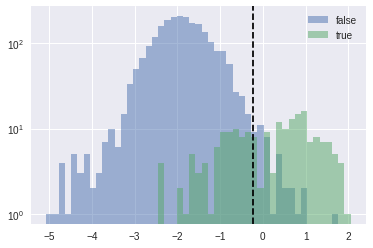

Endoplasmic reticulum 6 0.7255520504731862 -0.5991613232316373


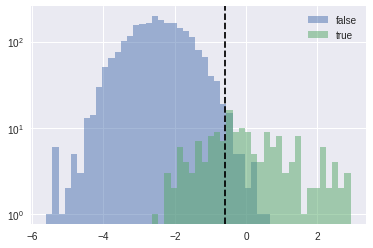

Golgi apparatus 7 0.7916666666666666 -0.24002870241939434


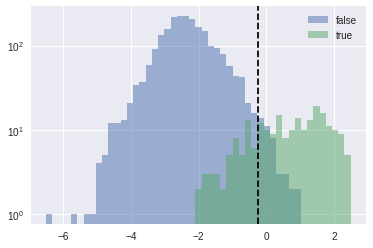

Peroxisomes 8 0.5263157894736842 0.13445943179392106


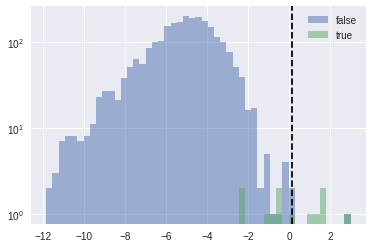

Endosomes 9 0.7692307692307693 0.00034967600486954795


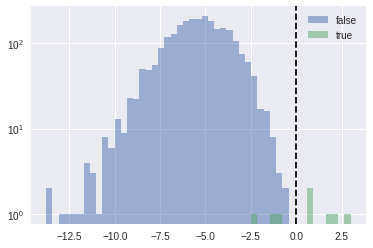

Lysosomes 10 0.9090909090909091 -0.15456420144353877


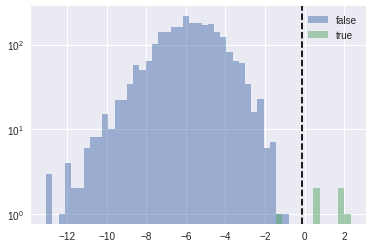

Intermediate filaments 11 0.8181818181818181 -0.12423693455238187


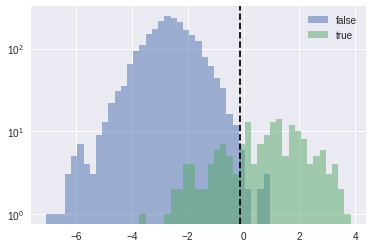

Actin filaments 12 0.6971428571428572 -0.4325723629769196


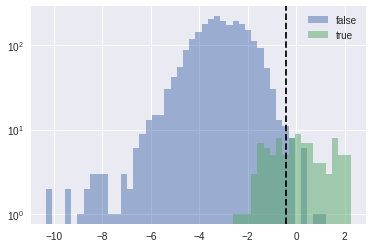

Focal adhesion sites 13 0.6938775510204082 -0.6342833805506879


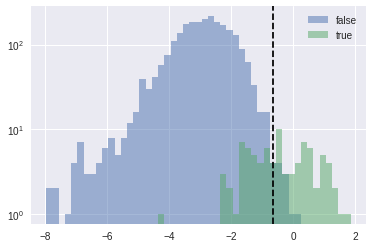

Microtubules 14 0.8999999999999999 -0.3108503396699596


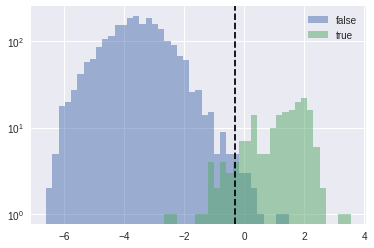

Microtubule ends 15 0.6666666666666665 -0.37281224210765057


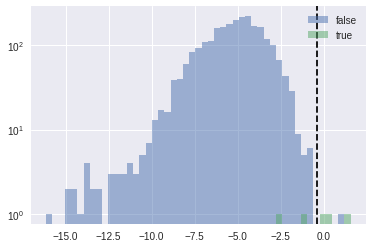

Cytokinetic bridge 16 0.4615384615384616 -0.7131535504040897


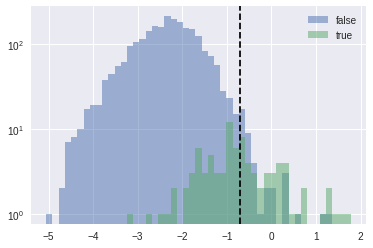

Mitotic spindle 17 0.5057471264367817 -0.8645939988829987


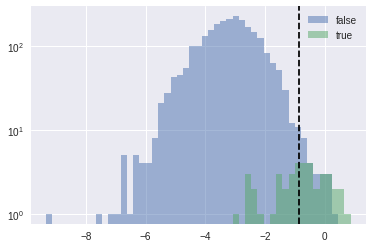

Microtubule organizing center 18 0.5283018867924528 -0.49389894044804494


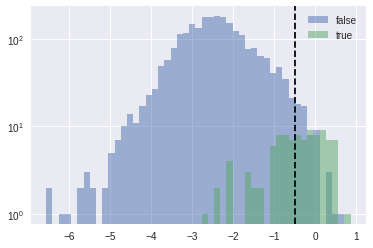

Centrosome 19 0.7058823529411764 -0.3752125993220628


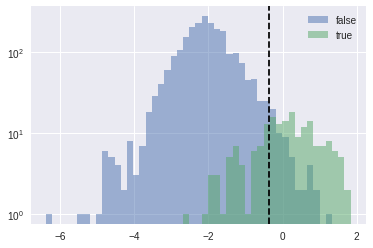

Lipid droplets 20 0.5660377358490566 -0.4884546501978712


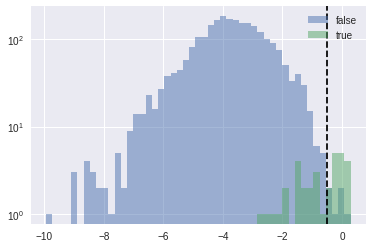

Plasma membrane 21 0.6628131021194605 -0.27937154947834275


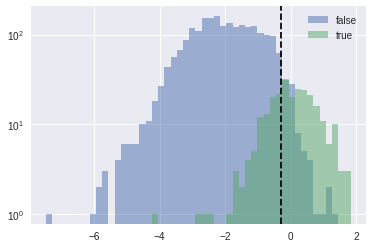

Cell junctions 22 0.6035502958579881 -0.3479521038362974


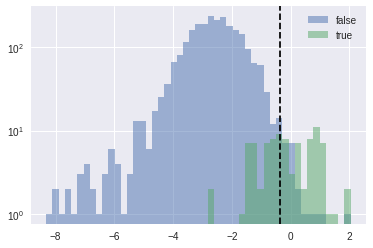

Mitochondria 23 0.8077858880778589 -0.329485123025947


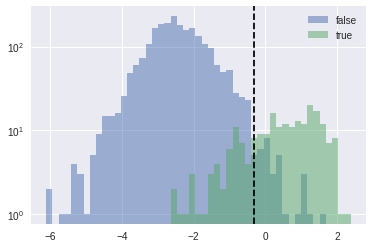

Aggresome 24 0.7407407407407407 -0.3041142759751846


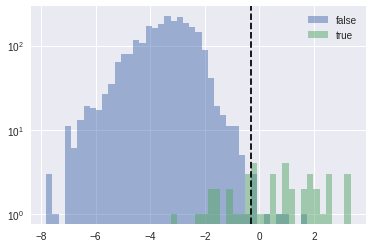

Cytosol 25 0.6765676567656765 -0.20637031126735947


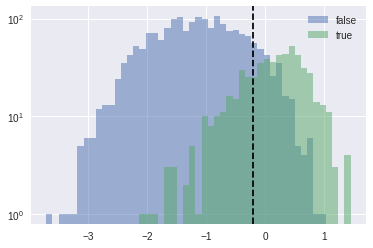

Cytoplasmic bodies 26 0.5454545454545455 -0.2566043017169709


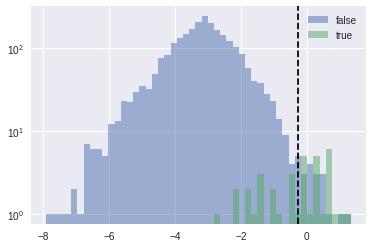

Rods & rings 27 0.6666666666666666 -0.22656138622652816


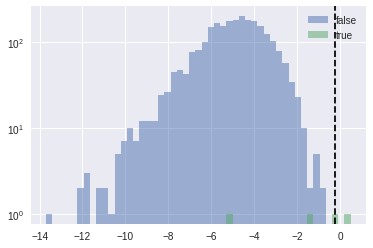

In [0]:
f1 = f1_score(y, pred>th, average=None)
for i in range(len(name_label_dict)):
    bins = np.linspace(pred[:,i].min(), pred[:,i].max(), 50)
    plt.hist(pred[y[:,i] == 0][:,i], bins, alpha=0.5, log=True, label='false')
    plt.hist(pred[y[:,i] == 1][:,i], bins, alpha=0.5, log=True, label='true')
    plt.legend(loc='upper right')
    print(name_label_dict[i],i, f1[i], th[i])
    plt.axvline(x=th[i], color='k', linestyle='--')
    plt.show()

### Submission

In [0]:
preds_t,y_t = learner.TTA(n_aug=8,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
pred_t = preds_t.mean(axis=-1)

**It is very important to keep the same order of ids as in the sample submission** https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/69366#409041 since the competition metric relies only on the order of recods ignoring IDs.

In [0]:
def save_pred(pred, th=0.0, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
    
    df = pd.DataFrame({'Id':learner.data.test_ds.fnames,'Predicted':pred_list})
    df.sort_values(by='Id').to_csv(fname, header=True, index=False)

Save predictions for thresholds calculated based on the validation set and constant value 0.0:

In [0]:
save_pred(pred_t,th,'protein_classification_v.csv')
save_pred(pred_t,0.0,'protein_classification_0.csv')

Similar to validation, additional adjustment may be done based on the public LB probing results (https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/68678) to predict approximately the same fraction of images of a particular class as expected from the public LB (I replaced 0 by 0.01 since there may be a rounding error leading to 0). Automatic fitting the thresholds based on the public LB statistics:


In [0]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [0]:
def Count_soft(preds,th=0.0,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [0]:
th_t = fit_test(pred_t,lb_prob)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.0): ',(pred_t > 0.0).mean(axis=0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Thresholds:  [ 0.27837 -0.61872 -0.04293 -0.92517 -1.06374 -0.45275 -0.76461 -0.31226 -2.03977 -1.90806  0.      -0.50595
 -0.99595 -0.74031 -0.3102  -1.63359 -0.71006 -0.33734 -0.38092 -0.46241 -0.79035 -0.15203 -0.58912 -0.29153
 -0.32103  0.04239 -0.85357  0.     ]
Fractions:  [0.36242 0.04358 0.07546 0.05948 0.07477 0.07529 0.04341 0.07494 0.01008 0.01008 0.00026 0.04358 0.04358
 0.01427 0.04367 0.00983 0.02854 0.01419 0.02863 0.05922 0.00983 0.12545 0.02888 0.07503 0.01    0.22201
 0.02863 0.00009]
Fractions (th = 0.0):  [0.43659 0.03333 0.07332 0.02743 0.03239 0.047   0.01564 0.05845 0.00068 0.00043 0.00026 0.02777 0.01607
 0.0059  0.03675 0.00017 0.00957 0.00726 0.01051 0.03025 0.00197 0.09913 0.01282 0.05939 0.00761 0.24167
 0.00709 0.00009]


In [0]:
save_pred(pred_t,th_t,'protein_classification_f.csv')

Try using the threshold from validation set for classes not present in the public LB:

In [0]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'protein_classification_c.csv')

Try fitting thresholds based on the frequency of classes in the train dataset:

In [0]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([12885.,  1254.,  3621.,  1561.,  1858.,  2513.,  1008.,  2822.,    53.,    45.,    28.,  1093.,
          688.,   537.,  1066.,    21.,   530.,   210.,   902.,  1482.,   172.,  3777.,   802.,  2965.,
          322.,  8228.,   328.,    11.]),
 array([0.41468, 0.04036, 0.11654, 0.05024, 0.0598 , 0.08088, 0.03244, 0.09082, 0.00171, 0.00145, 0.0009 ,
        0.03518, 0.02214, 0.01728, 0.03431, 0.00068, 0.01706, 0.00676, 0.02903, 0.0477 , 0.00554, 0.12156,
        0.02581, 0.09542, 0.01036, 0.2648 , 0.01056, 0.00035]))

In [0]:
th_t = fit_test(pred_t,label_fraction)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Thresholds:  [ 0.0816  -0.42052 -0.70399 -0.77759 -0.86827 -0.51038 -0.54843 -0.5369  -0.91226 -0.75843 -0.      -0.28356
 -0.37881 -0.90294  0.12638 -0.3961  -0.41667  0.04131 -0.38423 -0.30198 -0.41853 -0.12839 -0.51886 -0.57124
 -0.3772  -0.04825 -0.29408 -0.     ]
Fractions:  [0.41489 0.04042 0.11639 0.04999 0.05982 0.08076 0.03256 0.09101 0.00171 0.00145 0.00026 0.03512 0.02222
 0.01709 0.03427 0.00068 0.01718 0.00675 0.02888 0.04751 0.0053  0.12092 0.02581 0.09511 0.01043 0.26431
 0.01043 0.00009]


In [0]:
from google.colab import files

files.download('protein_classification_f.csv')
files.download('protein_classification_v.csv')
files.download('protein_classification_0.csv')
files.download('protein_classification_c.csv')
files.download('protein_classification_t.csv')
